<a href="https://colab.research.google.com/github/Logeshwaran32/Industrial-Copper/blob/main/Copper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Importing libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read the CSV file into a pandas dataframe
df = pd.read_csv('/content/Copper_Set.xlsx - Result 1.csv')
df.head(5)

Null values, shape and data types before dealing with incorrect data

In [ ]:
df.shape

In [ ]:
# missing values
missing_values_count = df.isnull().sum()
print(missing_values_count)

In [ ]:
df.info()

Dealing with data in wrong format

In [48]:
# for categorical variables, this step is ignored
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')
df['customer'] = pd.to_numeric(df['customer'], errors='coerce')
df['country'] = pd.to_numeric(df['country'], errors='coerce')
df['application'] = pd.to_numeric(df['application'], errors='coerce')
df['thickness'] = pd.to_numeric(df['thickness'], errors='coerce')
df['width'] = pd.to_numeric(df['width'], errors='coerce')
df['material_ref'] = df['material_ref'].str.lstrip('0')
df['product_ref'] = pd.to_numeric(df['product_ref'], errors='coerce')
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date
df['selling_price'] = pd.to_numeric(df['selling_price'], errors='coerce')

Nan values and shape after dealing with data in wrong format

In [ ]:
missing_values_count = df.isnull().sum()
print(missing_values_count)
print(df.shape)
df.info()

Dealing with Missing Values

In [50]:
# material_ref has large set of null values, so replacing them with unknown
df['material_ref'].fillna('unknown', inplace=True)
# deleting the remaining null values as they are less than 1% of data which can be neglected
df = df.dropna()

In [ ]:
missing_values_count = df.isnull().sum()
print(missing_values_count)
print(df.shape)

In [52]:
df_p=df.copy()

PLOTTING

In [ ]:
# ['quantity tons','selling_price','application','thickness','width', 'country']
# ['status','item type']

df_p['quantity tons']   # skewed
df_p['country']
df_p['application']
df_p['thickness']       # skewed
df_p['width']
df_p['selling_price']   # skewed

import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df_p['quantity tons'])
plt.show()
sns.distplot(df_p['country'])
plt.show()
sns.distplot(df_p['application'])
plt.show()
sns.distplot(df_p['thickness'])
plt.show()
sns.distplot(df_p['width'])
plt.show()
sns.distplot(df_p['selling_price'])
plt.show()

In [ ]:
import numpy as np
mask1 = df_p['selling_price'] <= 0
print(mask1.sum())
df_p.loc[mask1, 'selling_price'] = np.nan

mask1 = df_p['quantity tons'] <= 0
print(mask1.sum())
df_p.loc[mask1, 'quantity tons'] = np.nan

mask1 = df_p['thickness'] <= 0
print(mask1.sum())

In [ ]:
df_p.isnull().sum()

In [ ]:
df_p.dropna(inplace=True)
len(df_p)

In [ ]:
import numpy as np
df_p['selling_price_log'] = np.log(df_p['selling_price'])
sns.distplot(df_p['selling_price_log'])
plt.show()

df_p['quantity tons_log'] = np.log(df_p['quantity tons'])
sns.distplot(df_p['quantity tons_log'])
plt.show()

df_p['thickness_log'] = np.log(df_p['thickness'])
sns.distplot(df_p['thickness_log'])
plt.show()

In [ ]:
df_p.head()

In [ ]:
x=df_p[['quantity tons_log','application','thickness_log','width','selling_price_log','country','customer','product_ref']].corr()
sns.heatmap(x, annot=True, cmap="YlGnBu")

DECISION TREE REGRESSOR
Encode categorical features

Test and Train split

Define Hyperparameters for GridSearchCV

Train the DecisionTreeRegressor with best parameters

Evalution metrics

Predict the selling price for new values

Save the DecisionTreeRegressor model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

X=df_p[['quantity tons_log','status','item type','application','thickness_log','width','country','customer','product_ref']]
y=df_p['selling_price_log']
# encoding categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['item type']])
X_ohe = ohe.fit_transform(X[['item type']]).toarray()
ohe2 = OneHotEncoder(handle_unknown='ignore')
ohe2.fit(X[['status']])
X_be = ohe2.fit_transform(X[['status']]).toarray()
# independent features after encoding
X = np.concatenate((X[['quantity tons_log', 'application', 'thickness_log', 'width','country','customer','product_ref']].values, X_ohe, X_be), axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
# test and train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# decision tree
dtr = DecisionTreeRegressor()
# hyperparameters
param_grid = {'max_depth': [2, 5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']}
# gridsearchcv
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
# evalution metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean squared error:', mse)
print('R-squared:', r2)

In [ ]:
# Prepare the new sample
new_sample = np.array([[np.log(40), 10, np.log(250), 0, 28, 30202938, 1670798778, 'PL', 'Won']])

# One-hot encode categorical variables 'country' and 'customer'
new_sample_ohe = ohe.transform(new_sample[:, [7]]).toarray()
new_sample_be = ohe2.transform(new_sample[:, [8]]).toarray()

# Concatenate features with one-hot encoded representations
new_sample = np.concatenate((new_sample[:, [0, 1, 2, 3, 4, 5, 6]], new_sample_ohe, new_sample_be), axis=1)

# Scale the new sample using the same scaler used for training data
new_sample1 = scaler.transform(new_sample)

# Predict the selling price for the new sample using the best_model
new_pred = best_model.predict(new_sample1)

# Convert the predicted selling price back to the original scale (from logarithmic scale)
print('Predicted selling price:', np.exp(new_pred))

In [62]:
import pickle

# Save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)  # Save the best model

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)  # Save the scaler object

# Save the one-hot encoder for feature transformation
with open('t.pkl', 'wb') as f:
    pickle.dump(ohe, f)  # Save the first one-hot encoder

# Save another one-hot encoder for a different purpose
with open('s.pkl', 'wb') as f:
    pickle.dump(ohe2, f)  # Save the second one-hot encoder

In [ ]:
print(len(df_p))
df_p.head(3)

In [ ]:
df_c = df_p[df_p['status'].isin(['Won', 'Lost'])]
len(df_c)

DECISION TREE CLASSIFIER

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelBinarizer

Y = df_c['status']
X= df_c[['quantity tons_log','selling_price_log','item type','application','thickness_log','width','country','customer','product_ref']]

# encoding categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['item type']])
X_ohe = ohe.fit_transform(X[['item type']]).toarray()
be = LabelBinarizer()
be.fit(Y)
y = be.fit_transform(Y)
# independent features after encoding
X = np.concatenate((X[['quantity tons_log', 'selling_price_log','application', 'thickness_log', 'width','country','customer','product_ref']].values, X_ohe), axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# decision tree classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.9120521172638436
Confusion Matrix:
[[ 5690  1312]
 [ 1334 21750]]


In [ ]:
# Evalution Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Predict the status for a new sample
# 'quantity tons_log', 'selling_price_log','application', 'thickness_log', 'width','country','customer','product_ref']].values, X_ohe
new_sample = np.array([[np.log(700), np.log(956), 10, np.log(2),1500,28.0,30202938,1670798778,'W']])
new_sample_ohe = ohe.transform(new_sample[:, [8]]).toarray()
new_sample = np.concatenate((new_sample[:, [0,1,2, 3, 4, 5, 6,7]], new_sample_ohe), axis=1)
new_sample = scaler.transform(new_sample)
new_pred = dtc.predict(new_sample)
if new_pred==1:
    print('The status is: Won')
else:
    print('The status is: Lost')

In [81]:
# Saving the model
import pickle
with open('clsmodel.pkl', 'wb') as file:
    pickle.dump(dtc, file)
with open('cscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('ct.pkl', 'wb') as f:
    pickle.dump(ohe, f)

In [82]:
from google.colab import files

# List of file paths to download
file_paths = ['/content/model.pkl', '/content/scaler.pkl', '/content/t.pkl','/content/s.pkl','/content/clsmodel.pkl','/content/cscaler.pkl','/content/ct.pkl']

# Loop through each file path and download it
for file_path in file_paths:
    files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Streamlit App

In [ ]:
!pip install streamlit
!pip install streamlit_option_menu
!pip install pyngrok

In [83]:
%%writefile app.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
import streamlit as st
import re

st.set_page_config(layout="wide")

st.write("""
<div style='text-align:center'>
    <h1 style='color:#009999;'>Industrial Copper Modeling Application</h1>
</div>
""", unsafe_allow_html=True)

tab1, tab2 = st.tabs(["PREDICT SELLING PRICE", "PREDICT STATUS"])
with tab1:
    # Define the possible values for the dropdown menus
    status_options = ['Won', 'Draft', 'To be approved', 'Lost', 'Not lost for AM', 'Wonderful', 'Revised', 'Offered',
                      'Offerable']
    item_type_options = ['W', 'WI', 'S', 'Others', 'PL', 'IPL', 'SLAWR']
    country_options = [28., 25., 30., 32., 38., 78., 27., 77., 113., 79., 26., 39., 40., 84., 80., 107., 89.]
    application_options = [10., 41., 28., 59., 15., 4., 38., 56., 42., 26., 27., 19., 20., 66., 29., 22., 40., 25., 67.,
                           79., 3., 99., 2., 5., 39., 69., 70., 65., 58., 68.]
    product = ['611112', '611728', '628112', '628117', '628377', '640400', '640405', '640665',
               '611993', '929423819', '1282007633', '1332077137', '164141591', '164336407',
               '164337175', '1665572032', '1665572374', '1665584320', '1665584642', '1665584662',
               '1668701376', '1668701698', '1668701718', '1668701725', '1670798778', '1671863738',
               '1671876026', '1690738206', '1690738219', '1693867550', '1693867563', '1721130331', '1722207579']

    # Define the widgets for user input
    with st.form("my_form"):
        col1, col2, col3 = st.columns([5, 2, 5])
        with col1:
            st.write(' ')
            status = st.selectbox("Status", status_options, key=1)
            item_type = st.selectbox("Item Type", item_type_options, key=2)
            country = st.selectbox("Country", sorted(country_options), key=3)
            application = st.selectbox("Application", sorted(application_options), key=4)
            product_ref = st.selectbox("Product Reference", product, key=5)
        with col3:
            st.write(
                f'<h5 style="color:rgb(0, 153, 153,0.4);">NOTE: eg value given for reference, you can enter any value</h5>',
                unsafe_allow_html=True)
            quantity_tons = st.text_input("Enter Quantity Tons (eg:611728)")
            thickness = st.text_input("Enter thickness (eg:0.18 to 400)")
            width = st.text_input("Enter width (eg:2990)")
            customer = st.text_input("customer ID (eg:30408185)")
            submit_button = st.form_submit_button(label="PREDICT SELLING PRICE")
            st.markdown("""
                    <style>
                    div.stButton > button:first-child {
                        background-color: #009999;
                        color: white;
                        width: 100%;
                    }
                    </style>
                """, unsafe_allow_html=True)

        flag = 0
        pattern = "^(?:\d+|\d*\.\d+)$"
        for i in [quantity_tons, thickness, width, customer]:
            if re.match(pattern, i):
                pass
            else:
                flag = 1
                break

    if submit_button and flag == 1:
        if len(i) == 0:
            st.write("please enter a valid number space not allowed")
        else:
            st.write("You have entered an invalid value: ", i)

    if submit_button and flag == 0:
        import pickle

        with open(r"/content/model.pkl", 'rb') as file:
            loaded_model = pickle.load(file)
        with open(r'/content/scaler.pkl', 'rb') as f:
            scaler_loaded = pickle.load(f)

        with open(r"/content/t.pkl", 'rb') as f:
            t_loaded = pickle.load(f)

        with open(r"/content/s.pkl", 'rb') as f:
            s_loaded = pickle.load(f)

        new_sample = np.array([[np.log(float(quantity_tons)), application, np.log(float(thickness)), float(width),
                                country, float(customer), int(product_ref), item_type, status]])
        new_sample_ohe = t_loaded.transform(new_sample[:, [7]]).toarray()
        new_sample_be = s_loaded.transform(new_sample[:, [8]]).toarray()
        new_sample = np.concatenate((new_sample[:, [0, 1, 2, 3, 4, 5, 6, ]], new_sample_ohe, new_sample_be), axis=1)
        new_sample1 = scaler_loaded.transform(new_sample)
        new_pred = loaded_model.predict(new_sample1)[0]
        st.write('## :green[Predicted selling price:] ', np.exp(new_pred))

with tab2:
    with st.form("my_form1"):
        col1, col2, col3 = st.columns([5, 1, 5])
        with col1:
            cquantity_tons = st.text_input("Enter Quantity Tons (eg:1722207579)")
            cthickness = st.text_input("Enter thickness (eg:400)")
            cwidth = st.text_input("Enter width (eg:2990)")
            ccustomer = st.text_input("customer ID (eg:30408185)")
            cselling = st.text_input("Selling Price (eg:100001015)")

        with col3:
            st.write(' ')
            citem_type = st.selectbox("Item Type", item_type_options, key=21)
            ccountry = st.selectbox("Country", sorted(country_options), key=31)
            capplication = st.selectbox("Application", sorted(application_options), key=41)
            cproduct_ref = st.selectbox("Product Reference", product, key=51)
            csubmit_button = st.form_submit_button(label="PREDICT STATUS")

        cflag = 0
        pattern = "^(?:\d+|\d*\.\d+)$"
        for k in [cquantity_tons, cthickness, cwidth, ccustomer, cselling]:
            if re.match(pattern, k):
                pass
            else:
                cflag = 1
                break

    if csubmit_button and cflag == 1:
        if len(k) == 0:
            st.write("please enter a valid number space not allowed")
        else:
            st.write("You have entered an invalid value: ", k)

    if csubmit_button and cflag == 0:
        import pickle

        with open(r"/content/clsmodel.pkl", 'rb') as file:
            cloaded_model = pickle.load(file)

        with open(r'/content/cscaler.pkl', 'rb') as f:
            cscaler_loaded = pickle.load(f)

        with open(r"/content/ct.pkl", 'rb') as f:
            ct_loaded = pickle.load(f)

        # Predict the status for a new sample
        # 'quantity tons_log', 'selling_price_log','application', 'thickness_log', 'width','country','customer','product_ref']].values, X_ohe
        new_sample = np.array([[np.log(float(cquantity_tons)), np.log(float(cselling)), capplication,
                                np.log(float(cthickness)), float(cwidth), ccountry, int(ccustomer), int(product_ref),
                                citem_type]])
        new_sample_ohe = ct_loaded.transform(new_sample[:, [8]]).toarray()
        new_sample = np.concatenate((new_sample[:, [0, 1, 2, 3, 4, 5, 6, 7]], new_sample_ohe), axis=1)
        new_sample = cscaler_loaded.transform(new_sample)
        new_pred = cloaded_model.predict(new_sample)
        if new_pred == 1:
            st.write('## :green[The Status is Won] ')
        else:
            st.write('## :red[The status is Lost] ')

#st.write(f'<h6 style="color:rgb(0, 153, 153,0.35);">App Created by  Logeshwaran M </h6>', unsafe_allow_html=True)

Overwriting app.py


In [73]:
# Restart Streamlit app
!streamlit run app.py &>/dev/null&

In [74]:
!ngrok config add-authtoken 2bthDyyaiMiZYDL2k8MDnRD8GGs_6tghXCdi23Y49kGT8hSgc

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [75]:
from pyngrok import ngrok
public_url = ngrok.connect(addr='8501')
print(public_url)

NgrokTunnel: "https://3e83-35-223-144-135.ngrok-free.app" -> "http://localhost:8501"


Decision Tree Classifier:
Confusion Matrix:
[[ 5694  1308]
 [ 1350 21734]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      7002
           1       0.94      0.94      0.94     23084

    accuracy                           0.91     30086
   macro avg       0.88      0.88      0.88     30086
weighted avg       0.91      0.91      0.91     30086



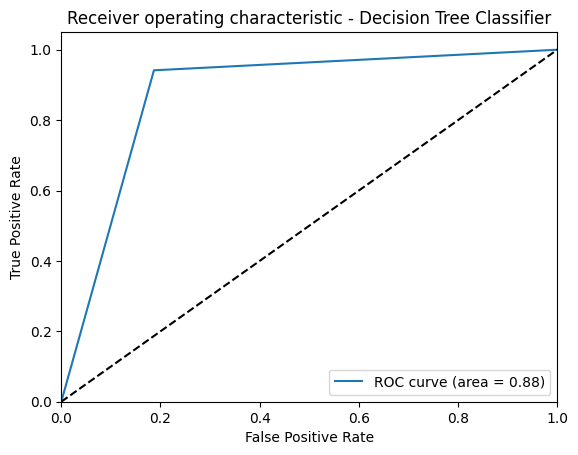

Decision Tree Regressor:
Confusion Matrix:
[[ 5694  1308]
 [ 1326 21758]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      7002
           1       0.94      0.94      0.94     23084

    accuracy                           0.91     30086
   macro avg       0.88      0.88      0.88     30086
weighted avg       0.91      0.91      0.91     30086



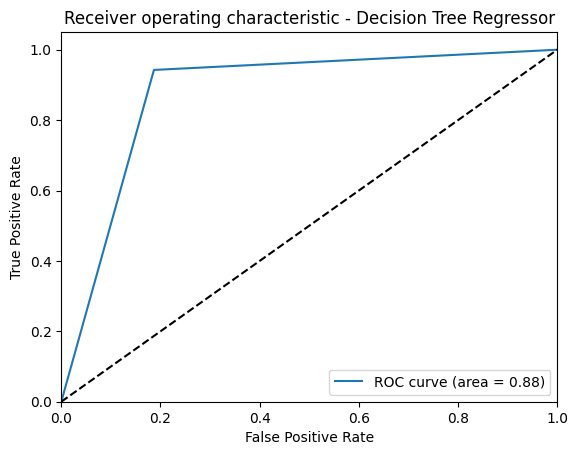

Mean squared error: 0.08754902612510802
R-squared: 0.5097167574123314
Random Forest Classifier:
Confusion Matrix:
[[ 5792  1210]
 [  819 22265]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      7002
           1       0.95      0.96      0.96     23084

    accuracy                           0.93     30086
   macro avg       0.91      0.90      0.90     30086
weighted avg       0.93      0.93      0.93     30086



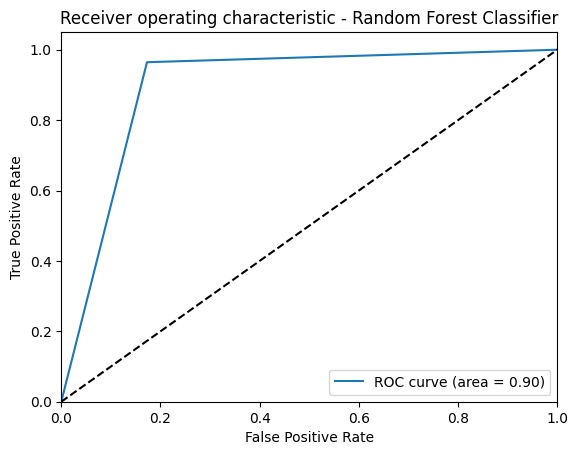

Random Forest Regressor:
Mean squared error: 0.04770975204414013
R-squared: 0.7328206495200941
Gradient Boosting Classifier:
Confusion Matrix:
[[ 2916  4086]
 [  938 22146]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.42      0.54      7002
           1       0.84      0.96      0.90     23084

    accuracy                           0.83     30086
   macro avg       0.80      0.69      0.72     30086
weighted avg       0.82      0.83      0.81     30086



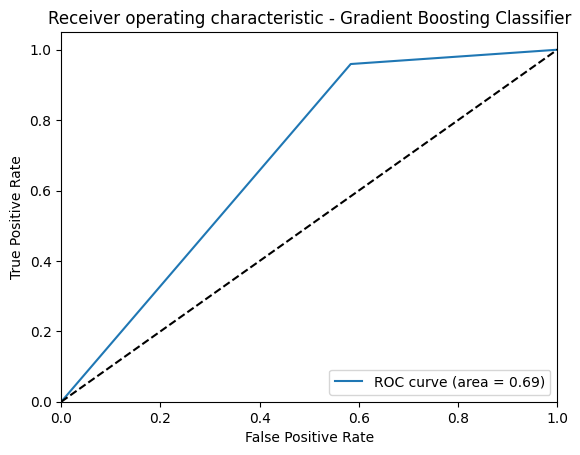

Gradient Boosting Regressor:
Mean squared error: 0.12064643348117572
R-squared: 0.32436798863688876
Logistic Regression Classifier:
Confusion Matrix:
[[ 1840  5162]
 [ 1278 21806]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.26      0.36      7002
           1       0.81      0.94      0.87     23084

    accuracy                           0.79     30086
   macro avg       0.70      0.60      0.62     30086
weighted avg       0.76      0.79      0.75     30086



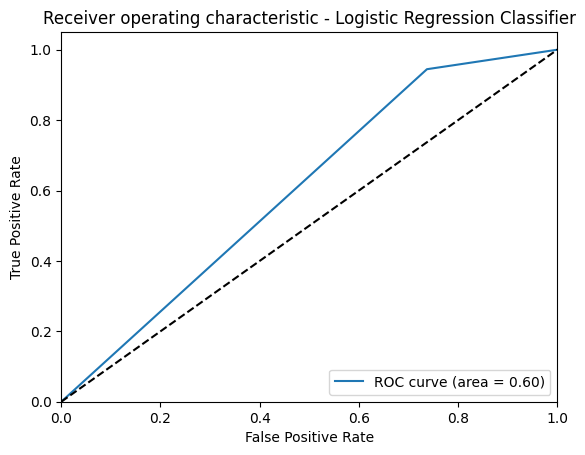

Linear Regression:
Mean squared error: 0.14990277953909684
R-squared: 0.1605295446655417
Mean Accuracy across all models: 0.6690269842640245
Mean ROC AUC across all models: 0.788541839742696


In [76]:
# Import necessary libraries for alternative models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store performance metrics
accuracies = []
roc_aucs = []

# Decision Tree Classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)
# Evaluation Metrics for Decision Tree Classifier
print("Decision Tree Classifier:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dtc))
print("Classification Report:")
print(classification_report(y_test, y_pred_dtc))
# ROC curve and AUC
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_test, y_pred_dtc)
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)
roc_aucs.append(roc_auc_dtc)
plt.figure()
plt.plot(fpr_dtc, tpr_dtc, label='ROC curve (area = %0.2f)' % roc_auc_dtc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()
# Calculate accuracy
accuracy_dtc = np.mean(y_pred_dtc == y_test)
accuracies.append(accuracy_dtc)

# Decision Tree Regressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)
# Evaluation Metrics for Decision Tree Regressor
print("Decision Tree Regressor:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dtr))
print("Classification Report:")
print(classification_report(y_test, y_pred_dtr))
# ROC curve and AUC
fpr_dtr, tpr_dtr, thresholds_dtr = roc_curve(y_test, y_pred_dtr)
roc_auc_dtr = auc(fpr_dtr, tpr_dtr)
roc_aucs.append(roc_auc_dtr)
plt.figure()
plt.plot(fpr_dtr, tpr_dtr, label='ROC curve (area = %0.2f)' % roc_auc_dtr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Decision Tree Regressor')
plt.legend(loc="lower right")
plt.show()
# Calculate accuracy
accuracy_dtr = np.mean(y_pred_dtr == y_test)
accuracies.append(accuracy_dtr)
mse_dtr = mean_squared_error(y_test, y_pred_dtr)
print('Mean squared error:', mse_dtr)
# R-squared
r2_dtr = r2_score(y_test, y_pred_dtr)
print('R-squared:', r2_dtr)

# Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
# Evaluation Metrics for Random Forest Classifier
print("Random Forest Classifier:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfc))
print("Classification Report:")
print(classification_report(y_test, y_pred_rfc))
# ROC curve and AUC
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_pred_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)
roc_aucs.append(roc_auc_rfc)
plt.figure()
plt.plot(fpr_rfc, tpr_rfc, label='ROC curve (area = %0.2f)' % roc_auc_rfc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()
# Calculate accuracy
accuracy_rfc = np.mean(y_pred_rfc == y_test)
accuracies.append(accuracy_rfc)

# Random Forest Regressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)
# Evaluation Metrics for Random Forest Regressor
print("Random Forest Regressor:")
# Mean squared error
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
print('Mean squared error:', mse_rfr)
# R-squared
r2_rfr = r2_score(y_test, y_pred_rfr)
print('R-squared:', r2_rfr)

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
# Evaluation Metrics for Gradient Boosting Classifier
print("Gradient Boosting Classifier:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))
print("Classification Report:")
print(classification_report(y_test, y_pred_gbc))
# ROC curve and AUC
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test, y_pred_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
roc_aucs.append(roc_auc_gbc)
plt.figure()
plt.plot(fpr_gbc, tpr_gbc, label='ROC curve (area = %0.2f)' % roc_auc_gbc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.show()
# Calculate accuracy
accuracy_gbc = np.mean(y_pred_gbc == y_test)
accuracies.append(accuracy_gbc)

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
# Evaluation Metrics for Gradient Boosting Regressor
print("Gradient Boosting Regressor:")
# Mean squared error
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print('Mean squared error:', mse_gbr)
# R-squared
r2_gbr = r2_score(y_test, y_pred_gbr)
print('R-squared:', r2_gbr)

# Logistic Regression Classifier
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# Evaluation Metrics for Logistic Regression Classifier
print("Logistic Regression Classifier:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
# ROC curve and AUC
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_aucs.append(roc_auc_lr)
plt.figure()
plt.plot(fpr_lr, tpr_lr, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Logistic Regression Classifier')
plt.legend(loc="lower right")
plt.show()
# Calculate accuracy
accuracy_lr = np.mean(y_pred_lr == y_test)
accuracies.append(accuracy_lr)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
# Evaluation Metrics for Linear Regression
print("Linear Regression:")
# Mean squared error
mse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg)
print('Mean squared error:', mse_lin_reg)
# R-squared
r2_lin_reg = r2_score(y_test, y_pred_lin_reg)
print('R-squared:', r2_lin_reg)

# Calculate mean accuracy and mean ROC AUC across all models
mean_accuracy = np.mean(accuracies)
mean_roc_auc = np.mean(roc_aucs)

print("Mean Accuracy across all models:", mean_accuracy)
print("Mean ROC AUC across all models:", mean_roc_auc)
